In [1]:
import kerchunk
import fsspec
import xarray as xr
import rioxarray
import rasterio
import ujson
import s3fs
import zarr 

import imagecodecs.numcodecs
imagecodecs.numcodecs.register_codecs()

from kerchunk.tiff import tiff_to_zarr
ex_path = 'https://github.com/fsspec/kerchunk/blob/main/kerchunk/tests/lcmap_tiny_cog_2019.tif?raw=true'
ex_path = 's3://carbonplan-scratch/AOT.tif'
ex_ds = xr.open_dataset(ex_path,engine='rasterio')


In [2]:
ex_ds

<xarray.Dataset>
Dimensions:      (band: 1, x: 1830, y: 1830)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4e+05 4e+05 4.001e+05 ... 5.097e+05 5.097e+05
  * y            (y) float64 1.3e+06 1.3e+06 1.3e+06 ... 1.19e+06 1.19e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

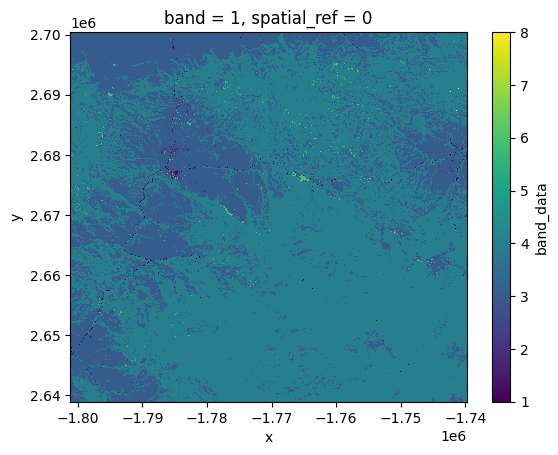

In [9]:
ex_ds.band_data.plot()

In [11]:

def generate_coords(attrs, shape):
    # Taken from kerchunk
    """Produce coordinate arrays for given variable

    Specific to GeoTIFF input attributes

    Parameters
    ----------
    attrs: dict
        Containing the geoTIFF tags, probably the root group of the dataset
    shape: tuple[int]
        The array size in numpy (C) order
    """
    import numpy as np

    height, width = shape[-2:]
    xscale, yscale, zscale = attrs["ModelPixelScale"][:3]
    x0, y0, z0 = attrs["ModelTiepoint"][3:6]
    out = {}
    out["x"] = np.arange(width) * xscale + x0 + xscale / 2
    out["y"] = np.arange(height) * -yscale + y0 - yscale / 2
    if len(shape) > 2:
        out["z"] = np.arange(shape[-3]) * zscale + z0 + zscale / 2
    return out


In [12]:
zt = tiff_to_zarr(ex_path, remote_options={'protocol':'https'}, target=None, target_options=None)
with open('lcmap.json', "wb") as f:
    f.write(ujson.dumps(zt).encode())

In [7]:
gcm = fsspec.get_mapper("reference://", fo='lcmap.json')
kds = xr.open_dataset(
    gcm, engine="zarr", backend_kwargs={"consolidated": False}

)
# z = zarr.open(gcm)
# attrs = dict(z.attrs)

In [16]:
kds[list(kds.variables)[0]].shape

(2048, 2048)

In [24]:
list(kds.dims)[2:]

['Y1', 'X1', 'Y2', 'X2']

In [60]:
kds = kds.drop_dims(list(kds.dims)[2:])

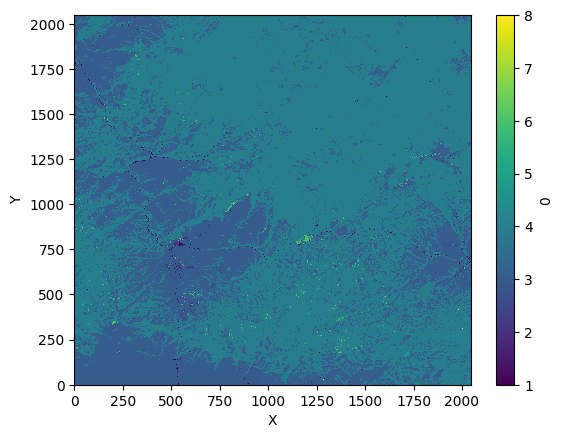

In [61]:
kds['0'].plot()

In [14]:
z.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, icon='table', name='0 (2048, 2048) uint8'…

In [62]:
out_coords = kerchunk.tiff.generate_coords(z.attrs, z[0].shape)


assert (ex_ds.x == out_coords["x"]).all()
assert (ex_ds.y == out_coords["y"]).all()


In [46]:
z.attrs

In [ ]:
epsg = attrs['GeographicTypeGeoKey']

In [32]:
kds

<xarray.Dataset>
Dimensions:  (Y: 2048, X: 2048, x: 2048, y: 2048)
Coordinates:
  * x        (x) float64 -1.801e+06 -1.801e+06 ... -1.74e+06 -1.74e+06
  * y        (y) float64 2.7e+06 2.7e+06 2.7e+06 ... 2.639e+06 2.639e+06
Dimensions without coordinates: Y, X
Data variables:
    0        (Y, X) float32 ...
Attributes: (12/30)
    multiscales:                 [{'datasets': [{'path': '0'}, {'path': '1'},...
    OVR_RESAMPLING_ALG:          NEAREST
    LAYOUT:                      IFDS_BEFORE_DATA
    BLOCK_ORDER:                 ROW_MAJOR
    BLOCK_LEADER:                SIZE_AS_UINT4
    BLOCK_TRAILER:               LAST_4_BYTES_REPEATED
    ...                          ...
    ProjNatOriginLongGeoKey:     -96.0
    ProjNatOriginLatGeoKey:      23.0
    ProjFalseEastingGeoKey:      0.0
    ProjFalseNorthingGeoKey:     0.0
    ModelPixelScale:             [30.0, 30.0, 0.0]
    ModelTiepoint:               [0.0, 0.0, 0.0, -1801185.0, 2700405.0, 0.0]

In [63]:
kds['X'] = out_coords["x"]
kds['Y'] = out_coords["y"]

In [64]:
kds.rename({'X': 'x','Y': 'y'})

<xarray.Dataset>
Dimensions:  (y: 2048, x: 2048)
Coordinates:
  * x        (x) float64 -1.801e+06 -1.801e+06 ... -1.74e+06 -1.74e+06
  * y        (y) float64 2.7e+06 2.7e+06 2.7e+06 ... 2.639e+06 2.639e+06
Data variables:
    0        (y, x) float32 ...
Attributes: (12/30)
    multiscales:                 [{'datasets': [{'path': '0'}, {'path': '1'},...
    OVR_RESAMPLING_ALG:          NEAREST
    LAYOUT:                      IFDS_BEFORE_DATA
    BLOCK_ORDER:                 ROW_MAJOR
    BLOCK_LEADER:                SIZE_AS_UINT4
    BLOCK_TRAILER:               LAST_4_BYTES_REPEATED
    ...                          ...
    ProjNatOriginLongGeoKey:     -96.0
    ProjNatOriginLatGeoKey:      23.0
    ProjFalseEastingGeoKey:      0.0
    ProjFalseNorthingGeoKey:     0.0
    ModelPixelScale:             [30.0, 30.0, 0.0]
    ModelTiepoint:               [0.0, 0.0, 0.0, -1801185.0, 2700405.0, 0.0]

In [66]:
kds

<xarray.Dataset>
Dimensions:  (Y: 2048, X: 2048)
Coordinates:
  * X        (X) float64 -1.801e+06 -1.801e+06 ... -1.74e+06 -1.74e+06
  * Y        (Y) float64 2.7e+06 2.7e+06 2.7e+06 ... 2.639e+06 2.639e+06
Data variables:
    0        (Y, X) float32 ...
Attributes: (12/30)
    multiscales:                 [{'datasets': [{'path': '0'}, {'path': '1'},...
    OVR_RESAMPLING_ALG:          NEAREST
    LAYOUT:                      IFDS_BEFORE_DATA
    BLOCK_ORDER:                 ROW_MAJOR
    BLOCK_LEADER:                SIZE_AS_UINT4
    BLOCK_TRAILER:               LAST_4_BYTES_REPEATED
    ...                          ...
    ProjNatOriginLongGeoKey:     -96.0
    ProjNatOriginLatGeoKey:      23.0
    ProjFalseEastingGeoKey:      0.0
    ProjFalseNorthingGeoKey:     0.0
    ModelPixelScale:             [30.0, 30.0, 0.0]
    ModelTiepoint:               [0.0, 0.0, 0.0, -1801185.0, 2700405.0, 0.0]

In [ ]:
ex_ds.band_data.plot()

In [35]:
epsg = "4326"

In [44]:
kds

<xarray.Dataset>
Dimensions:      (Y: 2048, X: 2048, x: 2048, y: 2048)
Coordinates:
  * x            (x) float64 -1.801e+06 -1.801e+06 ... -1.74e+06 -1.74e+06
  * y            (y) float64 2.7e+06 2.7e+06 2.7e+06 ... 2.639e+06 2.639e+06
    spatial_ref  int64 0
Dimensions without coordinates: Y, X
Data variables:
    0            (Y, X) float32 ...
Attributes: (12/30)
    multiscales:                 [{'datasets': [{'path': '0'}, {'path': '1'},...
    OVR_RESAMPLING_ALG:          NEAREST
    LAYOUT:                      IFDS_BEFORE_DATA
    BLOCK_ORDER:                 ROW_MAJOR
    BLOCK_LEADER:                SIZE_AS_UINT4
    BLOCK_TRAILER:               LAST_4_BYTES_REPEATED
    ...                          ...
    ProjNatOriginLongGeoKey:     -96.0
    ProjNatOriginLatGeoKey:      23.0
    ProjFalseEastingGeoKey:      0.0
    ProjFalseNorthingGeoKey:     0.0
    ModelPixelScale:             [30.0, 30.0, 0.0]
    ModelTiepoint:               [0.0, 0.0, 0.0, -1801185.0, 2700405.0, 0.0]

In [43]:
ex_ds

<xarray.Dataset>
Dimensions:      (band: 1, x: 2048, y: 2048)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -1.801e+06 -1.801e+06 ... -1.74e+06 -1.74e+06
  * y            (y) float64 2.7e+06 2.7e+06 2.7e+06 ... 2.639e+06 2.639e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...